In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
import tensorflow
import tqdm
import glob

from tqdm import tqdm

from skimage.io import imread, imshow
# from skimage.transform import resize

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten, BatchNormalization, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix,precision_score, recall_score, f1_score
import seaborn as sns

%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   zoom_range = 0.4,
                                   rotation_range = 10,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1.0 / 255.0)

In [5]:
train_dataset  = train_datagen.flow_from_directory(directory ='/content/drive/My Drive/Waste_Control_Data/TRAIN',
                                                   target_size = (224,224),
                                                   class_mode = 'binary',
                                                   batch_size = 128,
                                                   subset = 'training')

Found 7473 images belonging to 2 classes.


In [6]:
valid_dataset = valid_datagen.flow_from_directory(directory = '/content/drive/My Drive/Waste_Control_Data/TRAIN',
                                                  target_size = (224,224),
                                                  class_mode = 'binary',
                                                  batch_size = 128,
                                                  subset = 'validation')

Found 1867 images belonging to 2 classes.


In [7]:
# Class Indices
train_dataset.class_indices

{'O': 0, 'R': 1}

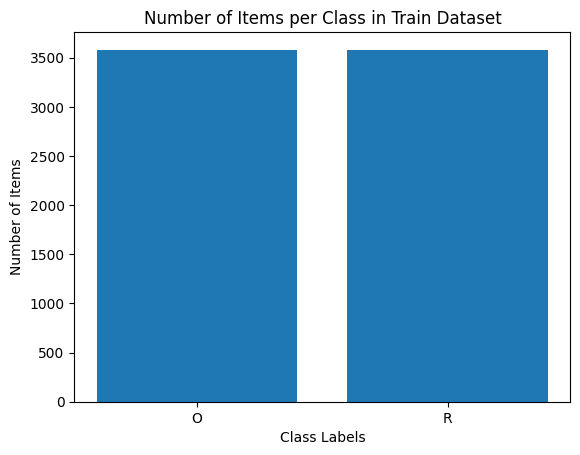

In [8]:
# Count the number of items for each label in the train dataset
train_labels_count = train_dataset.labels.sum(axis=0)

# Get the class labels
class_labels = train_dataset.class_indices.keys()

# Plot the bar graph
plt.bar(class_labels, train_labels_count)
plt.xlabel('Class Labels')
plt.ylabel('Number of Items')
plt.title('Number of Items per Class in Train Dataset')
plt.show()


In [9]:
from tensorflow.keras.applications import DenseNet121

# Define DenseNet121 base model
base_model = DenseNet121(input_shape=(224, 224, 3),
                          include_top=False,
                          weights='imagenet')


29084464/29084464 [==============================] - 0s 0us/step


In [10]:
# Freeze layers
for layer in base_model.layers:
    layer.trainable = False


In [11]:
#summary
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']

In [12]:
# Defining Layers
model=Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 dropout (Dropout)           (None, 7, 7, 1024)        0         
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 batch_normalization (Batch  (None, 50176)             200704    
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 1024)              51381248  
                                                                 
 batch_normalization_1 (Bat  (None, 1024)              4096      
 chNormalization)                                       

In [14]:
# Model Compile
OPT    = tensorflow.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='binary_crossentropy',
              metrics=[tensorflow.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)

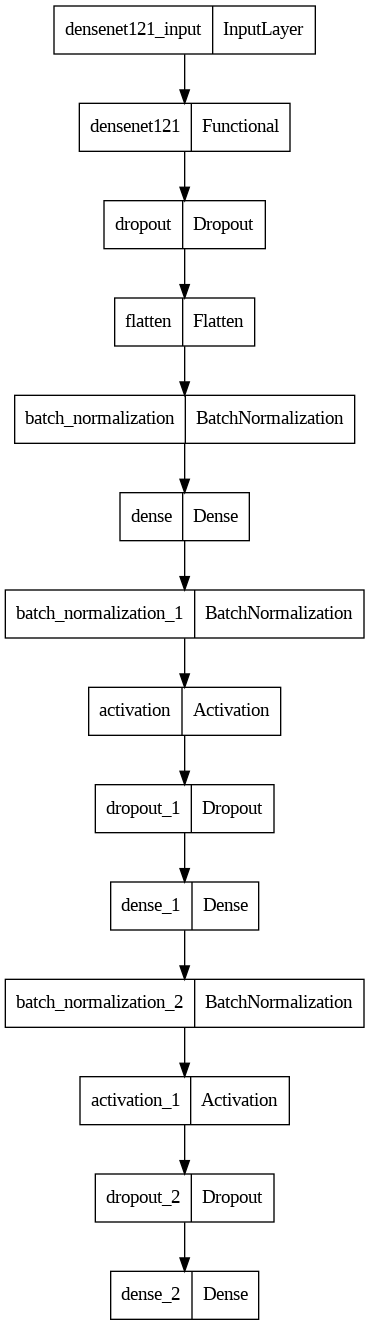

In [15]:
# Define Callbacks
filepath= './model_densenet.h5'


earlystopping = EarlyStopping(monitor='val_auc',
                              mode='max',
                              patience=5,
                              verbose=1)

checkpoint = ModelCheckpoint(filepath,
                             monitor='val_auc',
                             mode='max',
                             save_best_only=True,
                             verbose=1)

callback_list = [earlystopping, checkpoint]

# Plot the model architecture
plot_model(model, to_file='model_resnet.png')



In [16]:
# Model Training
history = model.fit(train_dataset,
                    validation_data=valid_dataset,
                    epochs=15,
                    callbacks=callback_list,
                    verbose=1)



Epoch 1/15
59/59 [==============================] - ETA: 0s - loss: 0.2199 - auc: 0.9724 
Epoch 1: val_auc improved from -inf to 0.93689, saving model to ./model_densenet.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


59/59 [==============================] - 2015s 34s/step - loss: 0.2199 - auc: 0.9724 - val_loss: 0.6389 - val_auc: 0.9369
Epoch 2/15
59/59 [==============================] - ETA: 0s - loss: 0.1252 - auc: 0.9900
Epoch 2: val_auc improved from 0.93689 to 0.94846, saving model to ./model_densenet.h5
59/59 [==============================] - 157s 3s/step - loss: 0.1252 - auc: 0.9900 - val_loss: 0.4038 - val_auc: 0.9485
Epoch 3/15
59/59 [==============================] - ETA: 0s - loss: 0.1101 - auc: 0.9919
Epoch 3: val_auc improved from 0.94846 to 0.96484, saving model to ./model_densenet.h5
59/59 [==============================] - 145s 2s/step - loss: 0.1101 - auc: 0.9919 - val_loss: 0.3249 - val_auc: 0.9648
Epoch 4/15
59/59 [==============================] - ETA: 0s - loss: 0.0901 - auc: 0.9943
Epoch 4: val_auc improved from 0.96484 to 0.97460, saving model to ./model_densenet.h5
59/59 [==============================] - 150s 3s/step - loss: 0.0901 - auc: 0.9943 - val_loss: 0.2415 - val_au

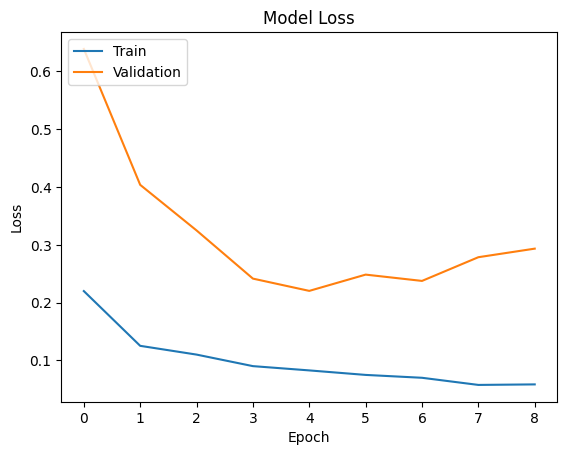

In [17]:
# Summarize model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


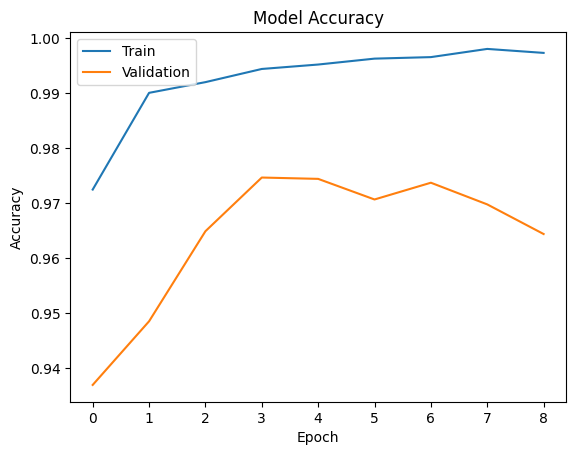

In [20]:
# Summarize model accuracy
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [19]:
# Test Data
test_data = test_datagen.flow_from_directory(directory='/content/drive/MyDrive/Waste_Control_Data/TEST',
                                             target_size=(224, 224),
                                             class_mode='binary',
                                             batch_size=128)


Found 1956 images belonging to 2 classes.


In [21]:
# evaluationg loss and Auc of test data
model.evaluate(test_data)

16/16 [==============================] - 417s 28s/step - loss: 0.3841 - auc: 0.9701


[0.38411179184913635, 0.9700824022293091]

1/1 [==============================] - 4s 4s/step
The image belongs to Organic waste category 


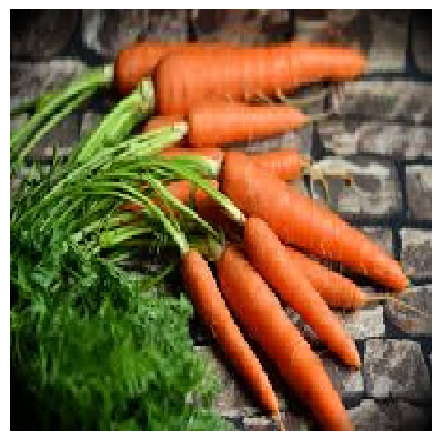

In [22]:
# Test Case:1 - ORGANIC
dic = test_data.class_indices
idc = {k:v for v,k in dic.items()}

img = load_img('/content/drive/MyDrive/Waste_Control_Data/TEST/O/O_12701.jpg', target_size=(224,224))
img = img_to_array(img)
img = img / 255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict(img)

if answer[0][0] > 0.5:
    print("The image belongs to Recycle waste category")
else:
    print("The image belongs to Organic waste category ")

1/1 [==============================] - 0s 40ms/step
The image belongs to Recycle waste category


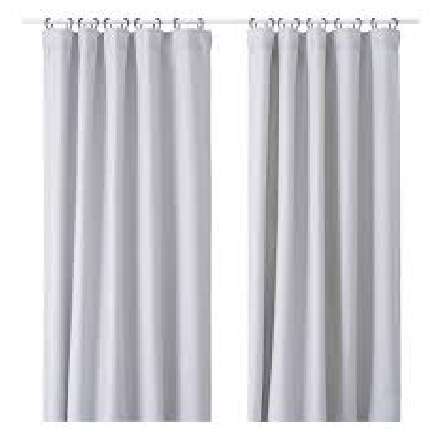

In [23]:
# Test Case:2 - RECYCLE

dic = test_data.class_indices
idc = {k:v for v,k in dic.items()}

img = load_img('/content/drive/MyDrive/Waste_Control_Data/TEST/R/R_10004.jpg', target_size=(224,224))
img = img_to_array(img)
img = img / 255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict(img)

if answer[0][0] > 0.5:
    print("The image belongs to Recycle waste category")
else:
    print("The image belongs to Organic waste category ")

In [25]:
test_data.reset()  # Reset generator to start of dataset
y_true = test_data.classes
y_pred = model.predict(test_data)
# y_pred_classes = np.argmax(y_pred, axis=1)

16/16 [==============================] - 13s 668ms/step


In [26]:
binary_values = (y_pred >= 0.5).astype(int)
reshaped_array = binary_values.reshape(1956)
reshaped_array.shape
y_true.shape

(1956,)

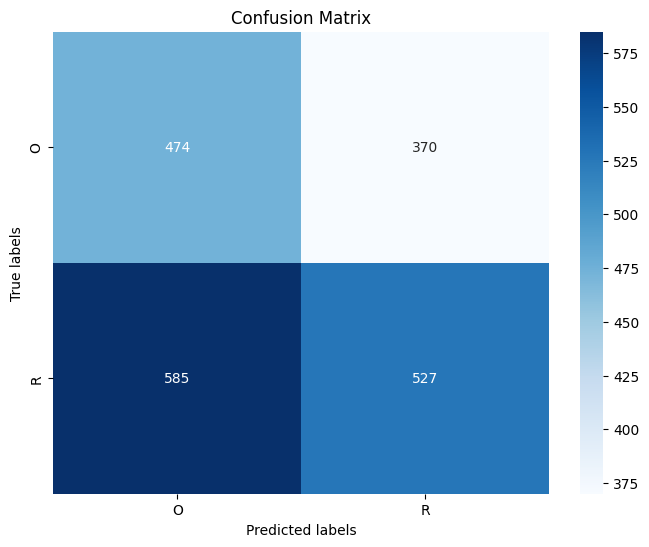

In [27]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, reshaped_array)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=test_data.class_indices, yticklabels=test_data.class_indices)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [28]:
binary_values_test = (y_pred >= 0.5).astype(int)

In [29]:
# Calculate Precision, Recall, F1 Score
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, binary_values_test, average='weighted')
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)


Precision: 0.5271386510636713
Recall: 0.5117586912065439
F1 Score: 0.5132139161346464
